In [85]:
import numpy as np
from matplotlib import pyplot as plt

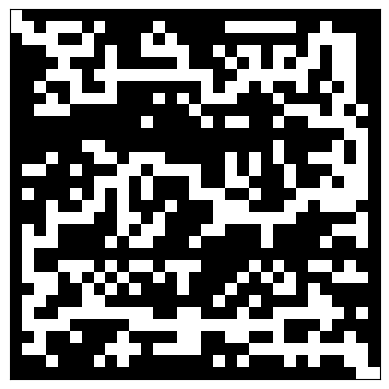

In [86]:
data = np.loadtxt("data/maze_5.csv", delimiter=",", dtype=bool)
fig = plt.figure()
ax = fig.add_subplot()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(data, cmap='binary')

In [87]:
def dijkstra(maze):
    end = len(maze) - 1
    reacheable = []
    previous_step = [((0,0), (0, 0))]
    
    steps = []

    while True:

        steps.append(previous_step)

        tmp = []

        for p in previous_step:
            point = p[1]
            reacheable.append(point)
            where = [(-1, 0), (0, 1), (0, -1), (1, 0)]
            if point[0] == 0:
                where.remove((-1, 0))
            if point[1] == 0:
                where.remove((0, -1))
            if point[0] == end:
                where.remove((1, 0))
            if point[1] == end:
                where.remove((0, 1))

            for to in where:
                p = (point[0] + to[0], point[1] + to[1])
                if not maze[p[0]][p[1]] and not (p in reacheable or p in previous_step or p in tmp):
                    tmp.append(tuple([point, p]))
                if p == (end, end):
                    steps.append(tmp)
                    return steps
        if(len(tmp) == 0):
           return steps
        previous_step = tmp
    return steps

In [88]:
def get_path(steps):
    i = len(steps) - 1
    path = [(len(data) - 1, len(data) - 1)]
    while ((0, 0), (0, 0)) not in steps[i]:
        for info in steps[i]:
            if path[-1] in info:
                path.append(info[0])
                i -= 1
                break
    return path

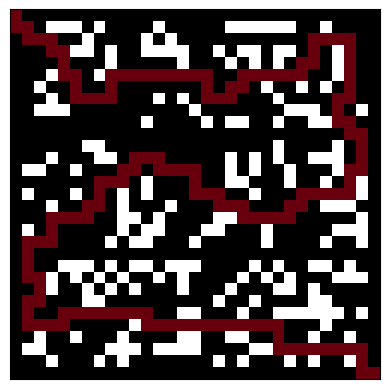

In [89]:
steps = dijkstra(data)
path = get_path(steps)
path_maze = np.ndarray(shape=[len(data), len(data)], dtype=bool)
path_maze.fill(False)
for point in path:
    path_maze[point[0]][point[1]] = True

path_masked = np.ma.masked_array(path_maze, data)
maze_masked = np.ma.masked_array(data, path_maze)

fig, ax = plt.subplots()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(path_masked, cmap='Reds', vmin=0, vmax=1)
ax.imshow(maze_masked, cmap='binary', vmin=0, vmax=1)
plt.show()